In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /#YOUR PATH TO THE NOTEBOOK FOLDER IN GOOGLE COLAB

In [ ]:
!pip install umap-learn
!pip install scikit-learn-extra
!pip install shap

In [ ]:
!pip install colorcet

In [ ]:
import numpy as np
import pandas as pd
import joblib
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from matplotlib.lines import Line2D

In [ ]:
from configuration import data_path as DATA_PATH
from configuration import results_root as RESULTS_ROOT
from configuration import results_path as RESULTS_PATH
from configuration import model_name as MODEL_NAME
from configuration import hyperparameter_tuning as HYPERPARAMETER_TUNNING
from configuration import feature_selection as FEATURE_SELECTION
from configuration import batchsize as BATCH_SIZE
from configuration import epochs as EPOCHS

In [ ]:
from footprint import Footprint

In [ ]:
from utils import plot_lineplot, plot_scatterplot, scatterplot_colorbar, scatterplot_legend, dimensionality_reduction_2D

In [ ]:
from clustering import hierarchical, tuning_hierarchical, plot_augmented_dendogram, plot_performance_distribution_clusters

In [ ]:
DATA_PATH

In [ ]:
SAVE_PATH = f"{RESULTS_PATH}/clustering"
os.makedirs(SAVE_PATH, exist_ok=True)
SAVE_PATH

In [ ]:
pd.set_option('display.max_columns', 10)

In [ ]:
def rank_clusters(labels, df, column, agg):
  """ Function to rank clusters according to some metric e.g, average ground truth algorithm performance. """
  data = pd.merge(labels, df, how='inner', left_index=True, right_index=True)
  data = data.groupby("cluster_id")[column].agg([agg]).reset_index().sort_values(by=agg)
  data["rank"] = np.arange(1, len(data)+1)

  return pd.Series(data['rank'].values, index=data['cluster_id']).to_dict()

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Custom Parula colormap data
parula_data = [
    [0.2081, 0.1663, 0.5292], [0.2116, 0.1898, 0.5777], [0.2123, 0.2138, 0.6270],
    [0.2081, 0.2386, 0.6771], [0.1959, 0.2645, 0.7279], [0.1707, 0.2919, 0.7792],
    [0.1253, 0.3242, 0.8303], [0.0591, 0.3598, 0.8683], [0.0117, 0.3875, 0.8820],
    [0.0060, 0.4086, 0.8828], [0.0165, 0.4266, 0.8786], [0.0329, 0.4430, 0.8720],
    [0.0498, 0.4586, 0.8641], [0.0629, 0.4737, 0.8554], [0.0723, 0.4887, 0.8467],
    [0.0779, 0.5039, 0.8384], [0.0793, 0.5200, 0.8312], [0.0749, 0.5375, 0.8263],
    [0.0641, 0.5570, 0.8240], [0.0488, 0.5772, 0.8228], [0.0343, 0.5966, 0.8199],
    [0.0265, 0.6137, 0.8135], [0.0239, 0.6287, 0.8038], [0.0231, 0.6418, 0.7913],
    [0.0228, 0.6535, 0.7768], [0.0267, 0.6642, 0.7607], [0.0384, 0.6743, 0.7436],
    [0.0590, 0.6838, 0.7254], [0.0843, 0.6928, 0.7062], [0.1133, 0.7015, 0.6859],
    [0.1453, 0.7098, 0.6646], [0.1801, 0.7177, 0.6424], [0.2178, 0.7250, 0.6193],
    [0.2586, 0.7317, 0.5954], [0.3022, 0.7376, 0.5712], [0.3482, 0.7424, 0.5473],
    [0.3953, 0.7459, 0.5244], [0.4420, 0.7481, 0.5033], [0.4871, 0.7491, 0.4840],
    [0.5300, 0.7491, 0.4661], [0.5709, 0.7485, 0.4494], [0.6099, 0.7473, 0.4337],
    [0.6473, 0.7456, 0.4188], [0.6834, 0.7435, 0.4044], [0.7184, 0.7411, 0.3905],
    [0.7525, 0.7384, 0.3768], [0.7858, 0.7356, 0.3633], [0.8185, 0.7327, 0.3498],
    [0.8507, 0.7299, 0.3360], [0.8824, 0.7274, 0.3217], [0.9139, 0.7258, 0.3063],
    [0.9450, 0.7261, 0.2886], [0.9739, 0.7314, 0.2666], [0.9938, 0.7455, 0.2403],
    [0.9990, 0.7653, 0.2164], [0.9955, 0.7861, 0.1967], [0.9880, 0.8066, 0.1794],
    [0.9789, 0.8271, 0.1633], [0.9697, 0.8481, 0.1475], [0.9626, 0.8705, 0.1309],
    [0.9589, 0.8949, 0.1132], [0.9598, 0.9218, 0.0948], [0.9661, 0.9514, 0.0755]
]

# Create the colormap
parula = LinearSegmentedColormap.from_list('parula', parula_data)

In [ ]:
def metarepresentations_visualization_2d(meta_representations_2d, df, join_columns, c, figsize, save_path):
  """ Visualization 2D. """
  data = meta_representations_2d.reset_index()
  data = pd.merge(data, df, how='left', left_on=join_columns, right_on=join_columns)

  target_ids = data["target_id"].unique()
  markers = ['o', 'x', 's']
  sns.set(style='white', font_scale=1)
  plt.figure(figsize=figsize)
  for i, target_id in enumerate(target_ids):
    data_filtered = data[data['target_id'] == target_id]
    plt.scatter(data_filtered["dim0"], data_filtered["dim1"], c=data_filtered[c], s=30, alpha=0.9, cmap=parula
            , marker=markers[i], label=target_id)
  # Adding color bar
  cbar = plt.colorbar()
  cbar.set_label(c)
  # Adding legend
  plt.legend()
  # Create legend with black-edged markers
  legend_elements = [Line2D([0], [0], marker=marker, color='w', label=category,
                            markerfacecolor='k', markeredgewidth=1.5, markeredgecolor='k', markersize=5)
                    for category, marker in zip(target_ids, markers)]
  plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
  plt.tight_layout()
  # save
  plt.savefig(f"{save_path}/{c}_2D.png", bbox_inches='tight', dpi=300)
  plt.savefig(f"{save_path}/{c}_2D.pdf", bbox_inches='tight', dpi=300)

  plt.show()

In [ ]:
# Load footprint
footprint = joblib.load(f"{RESULTS_PATH}/footprint.joblib")
print(f"\n\n--- Load data ---")
for dataset in ["train", "test"]:
  print(f"{dataset}: \n")
  print(footprint.data[f"X_{dataset}"].head())
  print(footprint.data[f"X_{dataset}"].shape)
  print("\n")
  print(footprint.data[f"y_{dataset}"].head())
  print(footprint.data[f"y_{dataset}"].shape)

### Explained Variance Ratio

In [ ]:
footprint.dim_reduction.explained_variance_ratio_.sum()

In [ ]:
# Load meta-representations 2D
meta_representations_2d = footprint.meta_representations_2d
meta_representations_2d

### Ground Truth 2D

In [ ]:
# Load ground truth data
y = footprint.data["y_test"].reset_index().melt(id_vars=["f_id", "i_id"]).rename(columns={"variable": "target_id", "value": "ground_truth"}).set_index(["f_id", "i_id", "target_id"])
y.head()

In [ ]:
y.shape

In [ ]:
y.max()

In [ ]:
y.min()

In [ ]:
# Plot
metarepresentations_visualization_2d(meta_representations_2d, df=y, join_columns=["f_id", "i_id", "target_id"], c="ground_truth", figsize=(6, 4), save_path=SAVE_PATH)

### Features 2D

In [ ]:
# Load feature data
X = footprint.data["X_test"].reset_index()
X

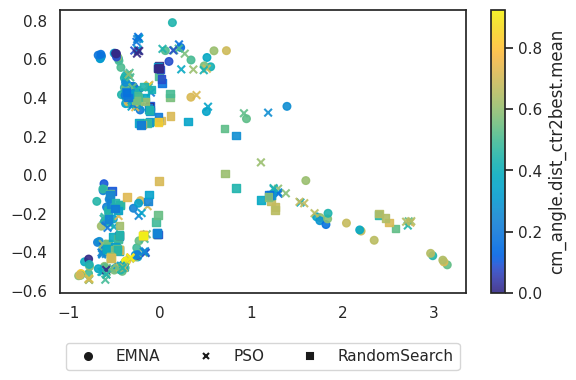

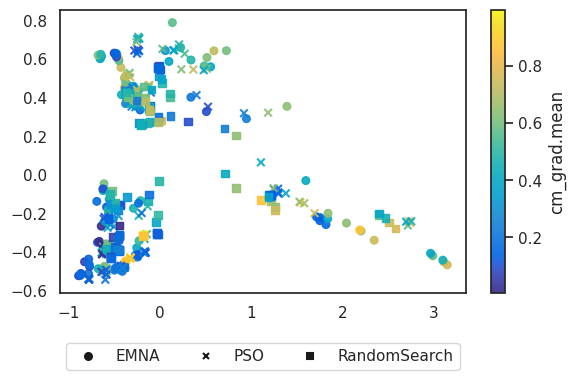

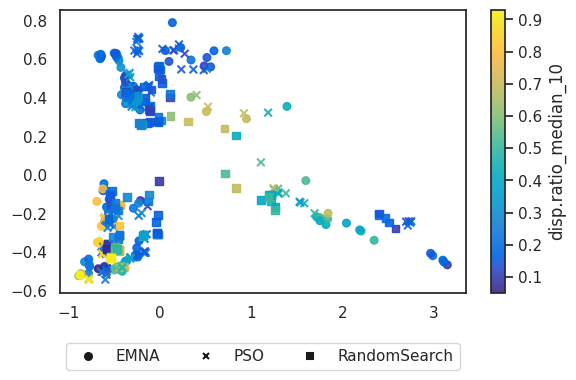

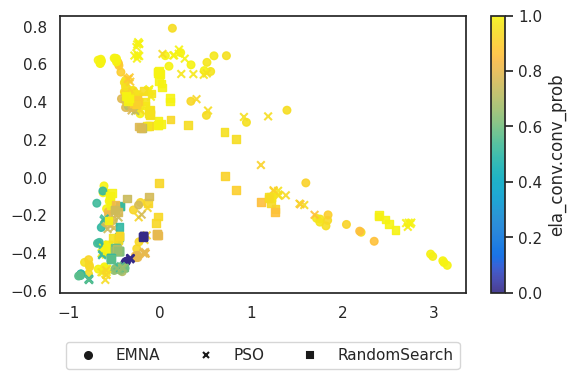

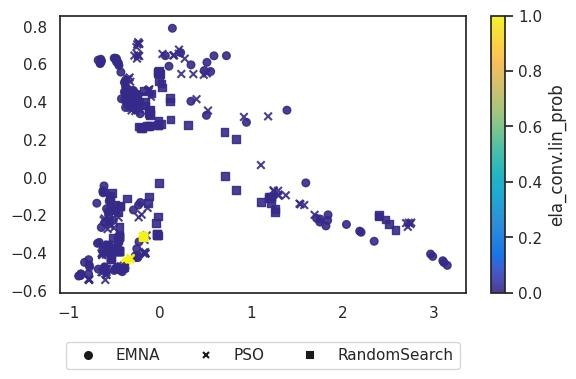

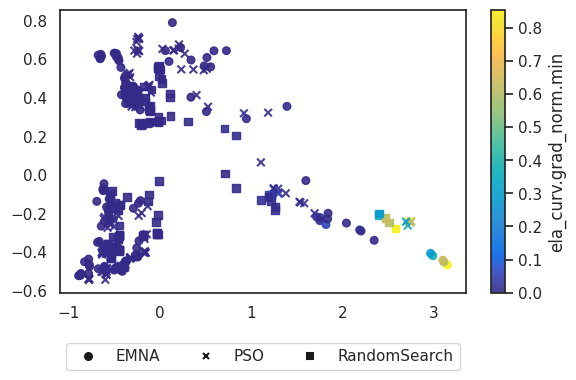

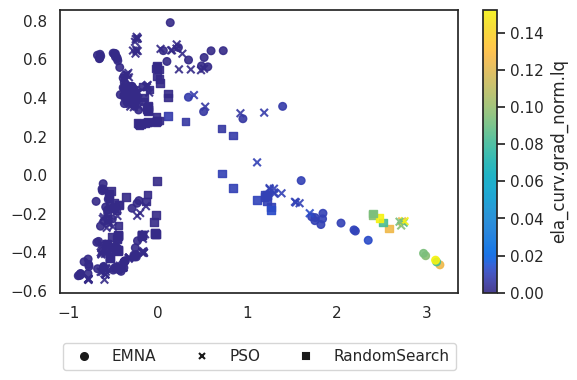

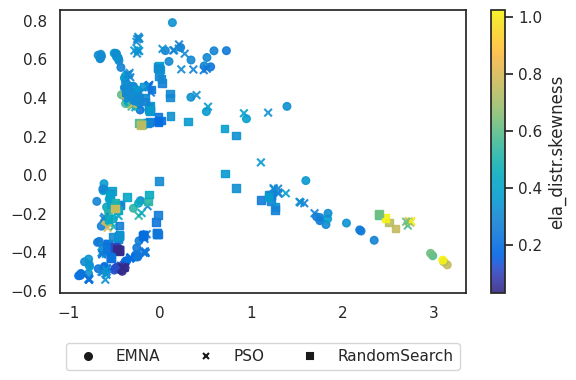

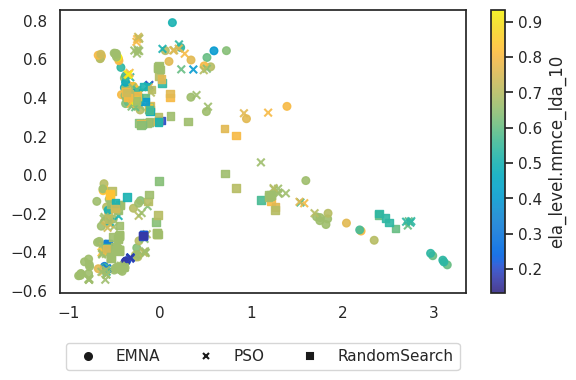

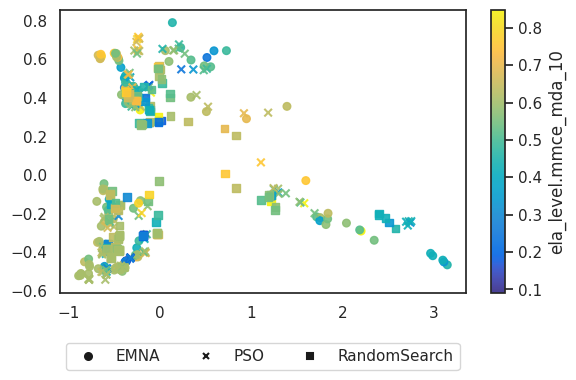

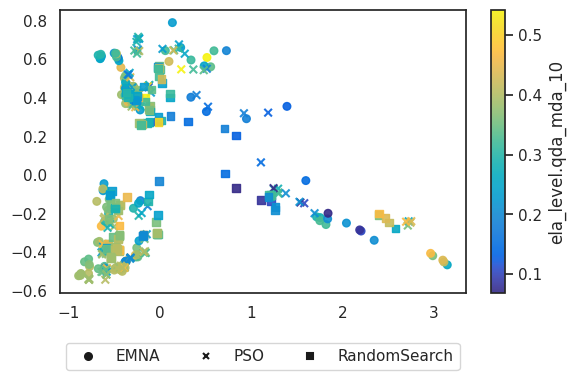

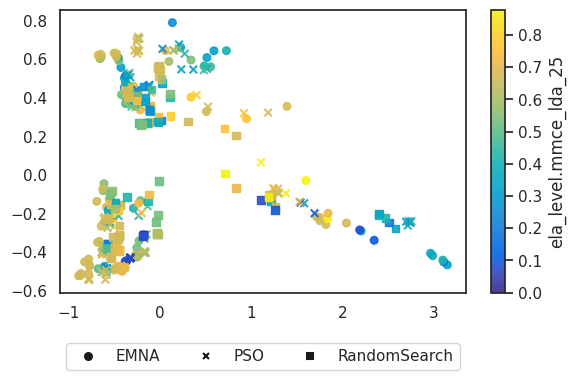

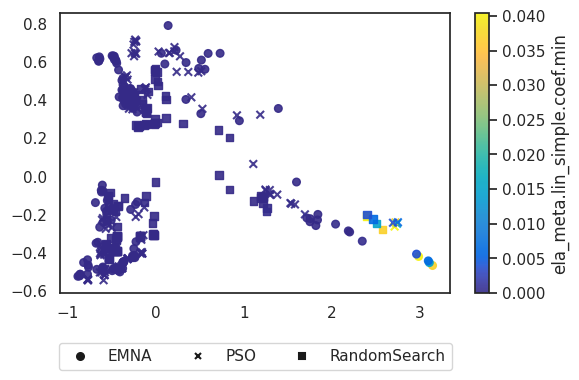

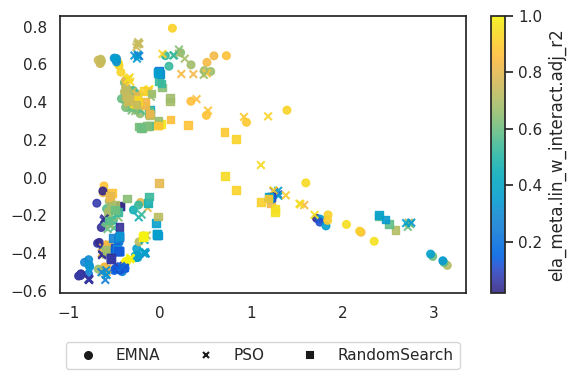

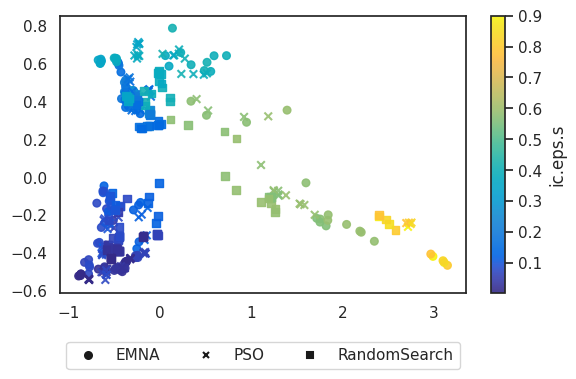

In [ ]:
# Plot
for column in X.drop(["f_id", "i_id"], axis=1):
  metarepresentations_visualization_2d(meta_representations_2d, df=X, join_columns=["f_id", "i_id"], c=column, figsize=(6, 4), save_path=SAVE_PATH)

In [ ]:
# Plot
X = X.set_index(["f_id", "i_id"])
X = (X -  X.min()) / ( X.max() -  X.min())
X = X.reset_index()
for column in X.drop(["f_id", "i_id"], axis=1):
  metarepresentations_visualization_2d(meta_representations_2d, df=X, join_columns=["f_id", "i_id"], c=column, figsize=(4.5, 3), save_path=SAVE_PATH)

## Clustering

In [ ]:
def meta_representation_clustering(meta_representations: pd.DataFrame, y: pd.DataFrame, save_path: str):
  labels_tuning, linkage_matrix, scores_tuning = tuning_hierarchical(data=meta_representations)
  # Clustering performance preview
  scores_tuning = scores_tuning.sort_values(by="score", ascending=False)
  print("Preview hierarchical tunning scores: ")
  print(scores_tuning.head(5))

  # Plot learning curve
  n_clusters = scores_tuning.head(1)["n_clusters"].values[0]
  plot_lineplot(df=scores_tuning.rename(columns={"score": "Silhouette score"}), figsize=(6, 3.3), x_line=11, font_scale=1.2, logscale=False
                , title=f"learning_curve-hierarchical-{n_clusters}", save_path=SAVE_PATH
                , x="n_clusters", y="Silhouette score", marker='o', hue="metric")
  # Plot dendrogram
  leaf_labels = meta_representations.reset_index()[["f_id", "i_id"]]
  leaf_labels["id"] = leaf_labels["f_id"].astype(str) + "_" + leaf_labels["i_id"].astype(str)
  plot_augmented_dendogram(linkage_matrix=linkage_matrix["cosine"], leaf_labels=leaf_labels["id"].values, color_threshold=None, figsize=(15, 5), font_scale=1, save=False, title=f"dendrogram", save_path=SAVE_PATH)

  # Choose the number of clusters
  n_clusters = int(input("n_clusters:"))
  metric =  input("metric:")
  # Get labels
  labels = labels_tuning[metric][n_clusters]
  print(labels.head())

  # Rank clusters
  data = pd.merge(y, labels, how='inner', left_index=True, right_index=True)
  # Grouping by 'label' and calculating both the mean and standard deviation of 'ground_truth'
  data = data.groupby("label")["ground_truth"].agg(['mean']).reset_index().sort_values(by="mean")
  data["rank"] = np.arange(1, len(data)+1)
  print(data)
  map = pd.Series(data['rank'].values, index=data['label']).to_dict()
  print(map)
  data['cluster_id'] = data['label'].map(map)

  labels["label"] = labels["label"].map(map)
  print(labels['label'].astype(str).value_counts().to_dict())
  labels = labels.rename(columns={"label": "cluster_id"})

  return labels_tuning, linkage_matrix, scores_tuning, n_clusters, labels, data

In [ ]:
# Load meta represenations
meta_representations = footprint.meta_representations

In [ ]:
labels_tuning, linkage_matrix, scores_tuning, n_clusters, labels, data = meta_representation_clustering(meta_representations, y, save_path=SAVE_PATH)

In [ ]:
labels

In [ ]:
data

### Clustering 2D

In [ ]:
def scatterplot_legend(data: pd.DataFrame, cluster_sizes: dict, figsize: tuple, font_scale: float, title: str, save_path: str, **kwargs):
  """ Function to plot a customized scatterplot with a legend. """
  sns.set(style='white', font_scale=font_scale)
  f, ax = plt.subplots(1, 1, figsize=figsize)
  sns.scatterplot(data=data, ax=ax, **kwargs)

  if cluster_sizes != None:
    # Get unique clusters and their corresponding colors from the scatter plot
    handles, labels = ax.get_legend_handles_labels()
    cluster_sizes = [f'Cluster {cluster} ({cluster_sizes[int(cluster)]})' for cluster in labels]
    # Create a custom legend
    plt.legend(handles, cluster_sizes, bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.1, ncol=2, title="cluster_id (mean ground truth performance)")

  plt.tight_layout()
  plt.savefig(f'{save_path}/{title}.png', bbox_inches='tight', dpi=300)
  plt.show()
  plt.close()

In [ ]:
scatterplot_legend(data=pd.merge(meta_representations_2d, labels, how='left',
                    left_index=True, right_index=True), cluster_sizes = dict(zip(data['cluster_id'], round(data['mean'], 2))),
                    figsize=(9, 3.5), font_scale=1,
                    title=f"hierarchical_clusters_2d-{n_clusters}",
                    save_path=SAVE_PATH,
                    x="dim0", y="dim1",
                    hue="cluster_id",
                    s=50, alpha=0.8, palette=sns.color_palette(cc.glasbey, len(labels["cluster_id"].unique())))

In [ ]:
footprint.clustering_labels = labels_tuning

# save fitted model
joblib.dump(footprint, f"{RESULTS_PATH}/footprint.joblib")

In [ ]:
import pandas as pd
def heatmap(df: pd.DataFrame, figsize, font_scale, path, **kwargs):
  """
  Function to plot a heatmap.
  """
  # Set up figure
  sns.set(style="white", font_scale=font_scale)
  plt.figure(figsize=figsize)
  # plot
  ax = sns.heatmap(df, **kwargs)
  # enhance plot
  # Adjust color bar tick label size
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=25)
  plt.tight_layout()
  ax.hlines([5, 10, 15], *ax.get_xlim())
  # save
  plt.savefig(f"{path}.png", dpi=300)
  plt.savefig(f"{path}.pdf")

  plt.show()
  plt.close()

In [ ]:
# Contagency matrix
def contagency_matrix(labels, df, join_columns, column, figsize):
  """ Function to create contagency matrix with clusters as rows and problem instances as columns. """
  n_clusters = len(labels["cluster_id"].unique())
  target_ids = list(labels["target_id"].unique())

  # Create pivot table
  pivot = pd.merge(labels, df, how='inner', left_on=join_columns, right_on=join_columns)
  pivot = pivot.pivot(index=["target_id", "cluster_id"], columns=["f_id", "i_id"], values=column)

  # Check each target_id for missing cluster_id, as problem instances from some target_id might not be in some clusters
  expected_labels = set(range(1, n_clusters+1))
  for target_id in target_ids:
    existing_labels = set(pivot.reset_index().loc[pivot.reset_index()['target_id'] == target_id, 'cluster_id'])
    missing_labels = expected_labels - existing_labels

    if len(missing_labels) != 0:
      for missing_label in missing_labels:
        print(missing_label)
        pivot.loc[(target_id, missing_label), :] = np.nan

  pivot = pivot.sort_index(level='target_id', ascending=True)

  # Display only f_id
  formatted_columns = []
  counter = 0  # This counter will keep track of the position within each f_id
  current_f_id = None

  for t in pivot.columns.tolist():
    # Check if the f_id has changed and reset the counter if it has
    if t[0] != current_f_id:
        current_f_id = t[0]
        counter = 0  # Reset counter for the new f_id group
    # Apply the formatting rule based on the counter
    if counter == 2 or counter % 5 == 2:  # Check if it's the third or every fifth element after the third
        formatted_columns.append('{}   '.format(t[0],t[1]))
    else:
        formatted_columns.append(' '.format(t[1]))
    counter += 1  # Increment the counter

  # Now apply the formatted column names to the DataFrame
  pivot.columns = formatted_columns

  print("Preview the final pivot table: ")
  print(pivot)

  # Create a figure and a set of subplots
  sns.set(style="white", font_scale=0.9)
  fig, axss = plt.subplots(nrows=len(target_ids), ncols=1, figsize=figsize)

  for i, target_id in enumerate(target_ids):
    df = pivot[pivot.index.get_level_values('target_id') == target_id]
    df = df.reset_index(level='target_id', drop=True)
    # Create the heatmap for this subplot
    sns.heatmap(df, annot=False, cmap="viridis", ax=axss[i], vmin=pivot.min().min(), vmax=pivot.max().max(), cbar_kws={"shrink": 0.75, "pad": 0.01}, cbar=False)

    # Draw a horizontal line after every 5th row
    num_rows = df.shape[0]
    axs=axss[i]
    for idx in range(n_clusters, num_rows, n_clusters):
      axs.axhline(idx, color='black', linewidth=2)
    for pos in np.arange(5, 120, 5):
      axs.vlines(pos, *axs.get_xlim(), colors='black', linewidth=1)
    for pos in np.arange(1, pivot.shape[1], 1):
      axs.hlines(pos, *axs.get_xlim(), colors='black', linestyles='dashed', linewidth=0.1)
    for pos in np.arange(1, pivot.shape[1], 1):
      axs.vlines(pos, *axs.get_xlim(), colors='black', linestyles='dashed', linewidth=0.1)

    axs.set_xlabel('')
    axs.set_ylabel('')
    axs.set_xticklabels(axs.get_xticklabels(), rotation=0)
    axs.tick_params(axis='y', rotation=0, labelsize=16)
    axs.tick_params(axis='x', labelsize=16)

    for _, spine in axs.spines.items():
      spine.set_visible(True)
      spine.set_color('black')
      spine.set_linewidth(0.5)

    # Adjust labels
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Rotate labels to 45 degrees
    axs.tick_params(axis='x', labelsize=10)
    axs.tick_params(axis='y', labelsize=10)
    axs.set_title(target_id)

  # Add a colorbar to the right of the subplots
  cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
  sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=pivot.min().min(), vmax=pivot.max().max()))
  sm.set_array([])
  cbar = fig.colorbar(sm, cax=cbar_ax)
  cbar.set_label(column, rotation=270, labelpad=20)

  # Set common x-label and y-label
  fig.text(0.5, 0.035, 'f_id', ha='center', va='center')
  fig.text(0.1, 0.5, 'cluster_id', ha='center', va='center', rotation='vertical')
  fig.subplots_adjust(hspace=0.3)

  plt.savefig(f'{SAVE_PATH}/coverage_matrix_{n_clusters}.png', bbox_inches='tight', dpi=300)
  plt.savefig(f'{SAVE_PATH}/coverage_matrix_{n_clusters}.pdf', bbox_inches='tight', dpi=300)
  plt.show()

n_clusters = 14
if n_clusters == 3:
  figsize=(22, 4)
elif n_clusters == 5:
  figsize=(22, 7)
elif n_clusters >= 10:
  figsize=(22, 7)

contagency_matrix(labels.reset_index(), y.reset_index(), join_columns=["f_id", "i_id", "target_id"], column="ground_truth", figsize=figsize)